# Simulate cross-resonance

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython.core.display import HTML

## Plotting machinery

In [2]:
HTML("""
<style>
.jp-RenderedImage {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
def cmap(name: str, n: int):
    return mpl.colormaps[name](np.linspace(0, 1, n))

In [4]:
# adapted from Qibo
# https://github.com/qiboteam/qibo/blob/master/src/qibo/ui/bloch.py


def _sphere():
    phi, theta = np.mgrid[0.0 : np.pi : 100j, 0.0 : 2.0 * np.pi : 100j]
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    return x, y, z


def _axis():
    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.zeros(100)
    x = np.sin(theta)
    y = np.cos(theta)
    return x, y, z


def _parallel(z):
    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.full(100, z)
    r = np.sqrt(1 - z[0] ** 2)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y, z


def _meridian(phi):
    theta = np.linspace(0, 2 * np.pi, 100)
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z


def bloch_sphere(**kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(
        projection="3d", elev=kwargs.get("elev", 15), azim=kwargs.get("azim", 30)
    )
    # Empty sphere
    ax.plot_surface(*_sphere(), color="lavenderblush", alpha=0.2)

    # Axis
    x, y, z = _axis()
    combinations_axis = [(x, y, z), (z, x, y), (y, z, x)]

    # Axis lines
    line, zeros = np.linspace(-1, 1, 100), np.zeros(shape=(100))
    combinations_axis_line = [
        (line, zeros, zeros),
        (zeros, line, zeros),
        (zeros, zeros, line),
    ]

    # Meridian and Parallel
    phi = [(n + 1) * np.pi / 3 for n in range(6)]
    lat = (0.4, -0.4, 0.9, -0.9)
    meridian = lambda x: ax.plot(*_meridian(x), color="darkgrey")
    parallel = lambda x: ax.plot(*_parallel(x), color="darkgrey")

    # Axis, Axis lines, Meridians, Parallels
    with mpl.rc_context({"lines.linewidth": 0.6}):
        [ax.plot(*combinations_axis[i], color="darkgrey") for i in range(3)]
        # [ax.plot(*combinations_axis_line[i], color="darkgrey") for i in range(3)]
        # [meridian(p) for p in phi]
        # [parallel(l) for l in lat]

    ax.axis("off")
    scale = 1 / 1.4
    ax.set_xlim(np.array([-1, 1]) * scale)
    ax.set_ylim(np.array([-1, 1]) * scale)
    ax.set_zlim(np.array([-1, 1]) * scale * 0.8)
    return fig, ax

## Simulation

In [5]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])


def rx(theta: float) -> np.ndarray:
    return scipy.linalg.expm(-1j * theta * x / 2) / 1j


def ry(theta: float) -> np.ndarray:
    return scipy.linalg.expm(-1j * theta * y / 2) / 1j


def rz(theta: float) -> np.ndarray:
    return scipy.linalg.expm(-1j * theta * z / 2) / 1j


def rzx(theta: float) -> np.ndarray:
    c = np.cos(theta / 2)
    s = np.sin(theta / 2)
    gate = np.zeros((4, 4), dtype=np.complex128)
    gate[0, 0:2] = [c, -1j * s]
    gate[1, 0:2] = [-1j * s, c]
    gate[2, 2:4] = [c, 1j * s]
    gate[3, 2:4] = [1j * s, c]
    return gate


def cnot(theta: float) -> np.ndarray:
    zxq = rzx(theta).reshape((2, 2, 2, 2))
    cnotq = np.einsum("ijkl,km,ln->ijmn", zxq, rz(np.pi / 2), rx(np.pi / 2))
    cnotph = cnotq.reshape(4, 4)
    return cnotph * np.sqrt(2) / (-1 + 1j)

### Validate Pauli matrices

In [6]:
a = rz(np.pi / 2) @ np.ones(2) / np.sqrt(2)
a.conj() @ y @ a

np.complex128(0.9999999999999998+1.232595164407831e-32j)

In [7]:
a = rx(np.pi / 2) @ [1, 0]
a.conj() @ y @ a

np.complex128(-1.0000000000000002+0j)

In [8]:
a = ry(np.pi / 2) @ [1, 0]
a.conj() @ x @ a

np.complex128(1.0000000000000002+0j)

### Evolve

In [9]:
def expz(input_: np.ndarray, theta: float, bare: bool = False) -> float:
    gate = cnot if not bare else rzx
    r = gate(theta) @ input_
    return np.real(r.conj() @ np.kron(np.eye(2), z) @ r)

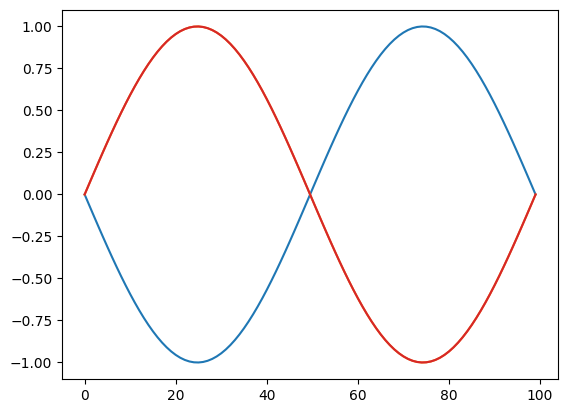

In [10]:
thetas = np.linspace(0, 2 * np.pi, 100)
plt.plot([expz([1, 0, 0, 0], th) for th in thetas])
plt.plot([expz([0, 1, 0, 0], th) for th in thetas])
plt.plot([expz([0, 0, 1, 0], th) for th in thetas], c="tab:red");

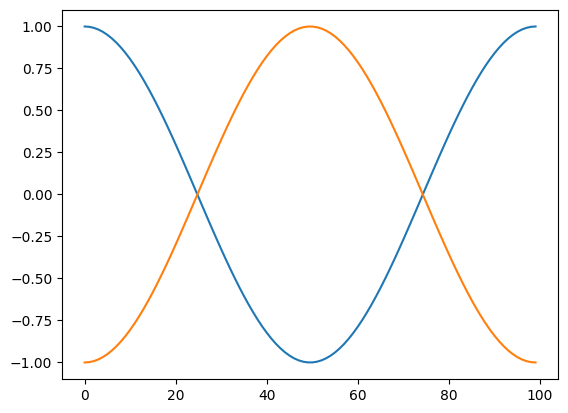

In [11]:
ts = np.linspace(0, 2 * np.pi, 100)
plt.plot([expz([1, 0, 0, 0], t, bare=True) for t in ts])
plt.plot([expz([0, 1, 0, 0], t, bare=True) for t in ts]);

In [36]:
zx = np.kron(z, x)
zz = np.kron(z, z)
ix = np.kron(np.eye(2), x)
iy = np.kron(np.eye(2), y)
iz = np.kron(np.eye(2), z)
it = np.stack([ix, iy, iz]).transpose((1, 0, 2))
zi = np.kron(z, np.eye(2))


def evol(t: float, coeffs: list[float]):
    o1 = coeffs[0]
    o2 = coeffs[1]
    zeta = coeffs[2]
    Onu = coeffs[3]
    Omu = coeffs[4]
    return scipy.linalg.expm(
        -1j * (-o1 / 2 * iz + -o2 / 2 * zi + zeta / 4 * zz + Onu * ix + Omu * zx) * t
    )


def expevolz(input_: np.ndarray, t: float, coeffs: list[float]) -> np.ndarray:
    r = evol(t, coeffs) @ input_
    return np.real(r.conj() @ (it @ r))

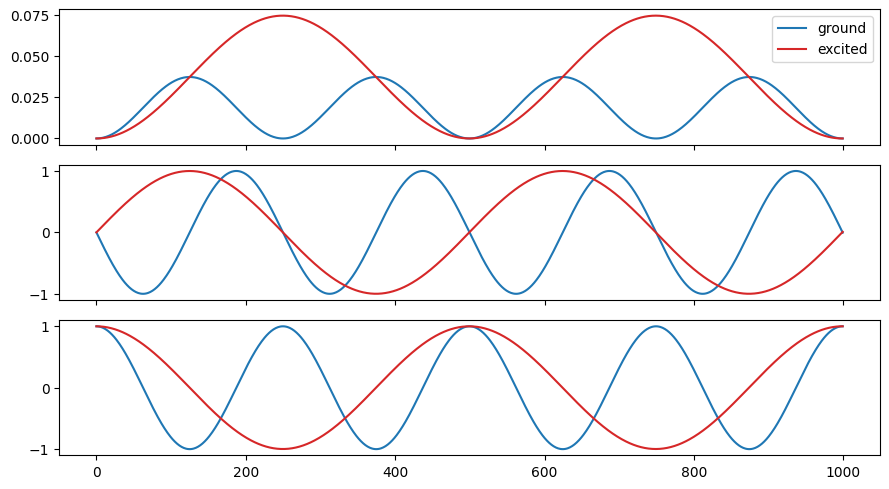

In [57]:
ts = np.linspace(0, np.pi, 1000)
coeffs = [0, 0, 0.3, 1, 3]
g = np.array([expevolz([1, 0, 0, 0], t, coeffs) for t in ts]).T
e = np.array([expevolz([0, 0, 1, 0], t, coeffs) for t in ts]).T
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(9, 5))
for ax, gc, ec in zip(axs, g, e):
    ax.plot(gc, label="ground")
    ax.plot(ec, c="tab:red", label="excited")
axs[0].legend()
fig.tight_layout()

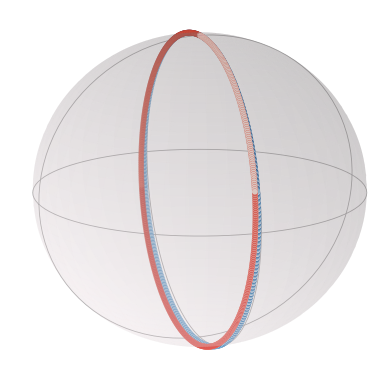

In [58]:
fig, ax = bloch_sphere(azim=70)
ax.scatter(*g, c=cmap("Blues", 1000), s=10)
ax.scatter(*e, c=cmap("Reds", 1000), s=10);